# Vertical search algo implemented using Python
> A tutorial demonstrating how to implement search using Python, sklearn, and networkx 

In [1]:
import networkx as nx
import pandas as pd
import os
import json
import ast
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
from IPython.display import Image
from IPython.core.display import HTML 
pd.set_option('display.max_colwidth',1000)

<ol><b>
    What are we trying to do here?
    <li>We want to create vertical search to find TED videos based on our query.</li>
    <li>Dataset: All video recordings of TED Talks uploaded on official TED website until Sept 2017.</li>
    <li>Dataset contains columns talk title, transcript, url, main speaker, related ted talks for any ted talk</b></ol>

In [26]:
path_to_data = os.getcwd() + "\\data\\"
ted_main_filepath = path_to_data + "ted_main.csv"
transcripts_filepath = path_to_data + "transcripts.csv"

ted_main_df = pd.read_csv(ted_main_filepath)
ted_main_df = ted_main_df[['title', 'url', 'related_talks']]
transcripts_df = pd.read_csv(transcripts_filepath)

print(ted_main_df.shape)
print(transcripts_df.shape)

#merge the two dataframes to create one. 
final_ted_df = transcripts_df.merge(ted_main_df, on="url")
print(final_ted_df.shape)

(2550, 3)
(2467, 2)
(2467, 4)


In [29]:
# Pagerank algorithm tries to find the most prominent web pages in a network of web pages. 
# Essentially pagerank of a webpage or node in the network is dependent on its immediate neighbour's rank and so and so forth.
# A node with a higher pagerank is cited by other highly pageranked nodes

# In our case of vertical search of TED videos based on search query, we will create a directed graph of ted videos as nodes
# and directed edge to all related ted videos from the source ted video.
# Assumption: If a ted video is in recommendations of high ranked ted videos it must be high ranked as well.

#To create a directed graph we will use networkx library
# we need to create a dataframe of all edges (source ted video, recommended ted video)
recommendations_df = final_ted_df[["title","related_talks"]]
print(recommendations_df)

                                                  title  \
0                           Do schools kill creativity?   
1                           Averting the climate crisis   
2                                      Simplicity sells   
3                                   Greening the ghetto   
4                       The best stats you've ever seen   
...                                                 ...   
2462  What we're missing in the debate about immigra...   
2463                    The most Martian place on Earth   
2464  What intelligent machines can learn from a sch...   
2465       A black man goes undercover in the alt-right   
2466  How a video game might help us build better ci...   

                                          related_talks  
0     [{'id': 865, 'hero': 'https://pe.tedcdn.com/im...  
1     [{'id': 243, 'hero': 'https://pe.tedcdn.com/im...  
2     [{'id': 1725, 'hero': 'https://pe.tedcdn.com/i...  
3     [{'id': 1041, 'hero': 'https://pe.tedcdn.com/i...  
4

In [32]:
def recommended_titles_list(reco_str):
    data = json.dumps(ast.literal_eval(reco_str))
    jdata = json.loads(data)
    titles_list = []
    for data in jdata:
        titles_list.append(data['title'])
    return titles_list

In [39]:
#Take each line from sheet and write to a graph with "title" and "related_title".
columns = ['title', 'related_title']
edges_df = pd.DataFrame(columns=columns)
for index, row in recommendations_df.iterrows():
    title = row['title']
    reco_list = recommended_titles_list(row['related_talks'])
    for reco_title in reco_list:
        edges_df = edges_df.append({'title':title, 'related_title':reco_title}, ignore_index=True)

print(edges_df.head(5))
# There are 14802 directed edges in the graph.
print(edges_df.shape)

                         title  \
0  Do schools kill creativity?   
1  Do schools kill creativity?   
2  Do schools kill creativity?   
3  Do schools kill creativity?   
4  Do schools kill creativity?   

                                       related_title  
0                  Bring on the learning revolution!  
1             How to escape education's death valley  
2  How to fix a broken school? Lead fearlessly, l...  
3                  Education innovation in the slums  
4                 A short intro to the Studio School  
(14802, 2)


In [37]:
# Create the directed graph from edges dataframe using networkx
di_reco_graph = nx.from_pandas_edgelist(edges_df,'title','related_title', create_using=nx.DiGraph())

In [161]:
#Print generic info about directed graph
print(nx.info(di_reco_graph))

# Pagerank is a variant of eigenvector. Hence we find eigenvectors for each node (ted_video)
eigenvector_dict = nx.eigenvector_centrality(di_reco_graph)

# normalize the eigenvectors (b/w 0 and 1)
factor=1.0/sum(eigenvector_dict.values())
normalised_eigenvector_dict = {k: v*factor for k, v in eigenvector_dict.items() }
#print(normalised_eigenvector_dict)
#print({k: v for k, v in sorted(normalised_eigenvector_dict.items(), key=lambda item: item[1], reverse = True)})

# Add the eigen vector to final_ted_df dataframe.
eigenvectors_df = pd.DataFrame(normalised_eigenvector_dict.items(), columns=['title', 'eigenvector_value'])
final_ted_df = final_ted_df.merge(eigenvectors_df,on="title")
print(final_ted_df.head(1))

Name: 
Type: DiGraph
Number of nodes: 2520
Number of edges: 14784
Average in degree:   5.8667
Average out degree:   5.8667
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             

In [128]:
#TODO: Insert graphs from gephi, and modularity analysis
edges_df.to_csv('graph_edges.csv')

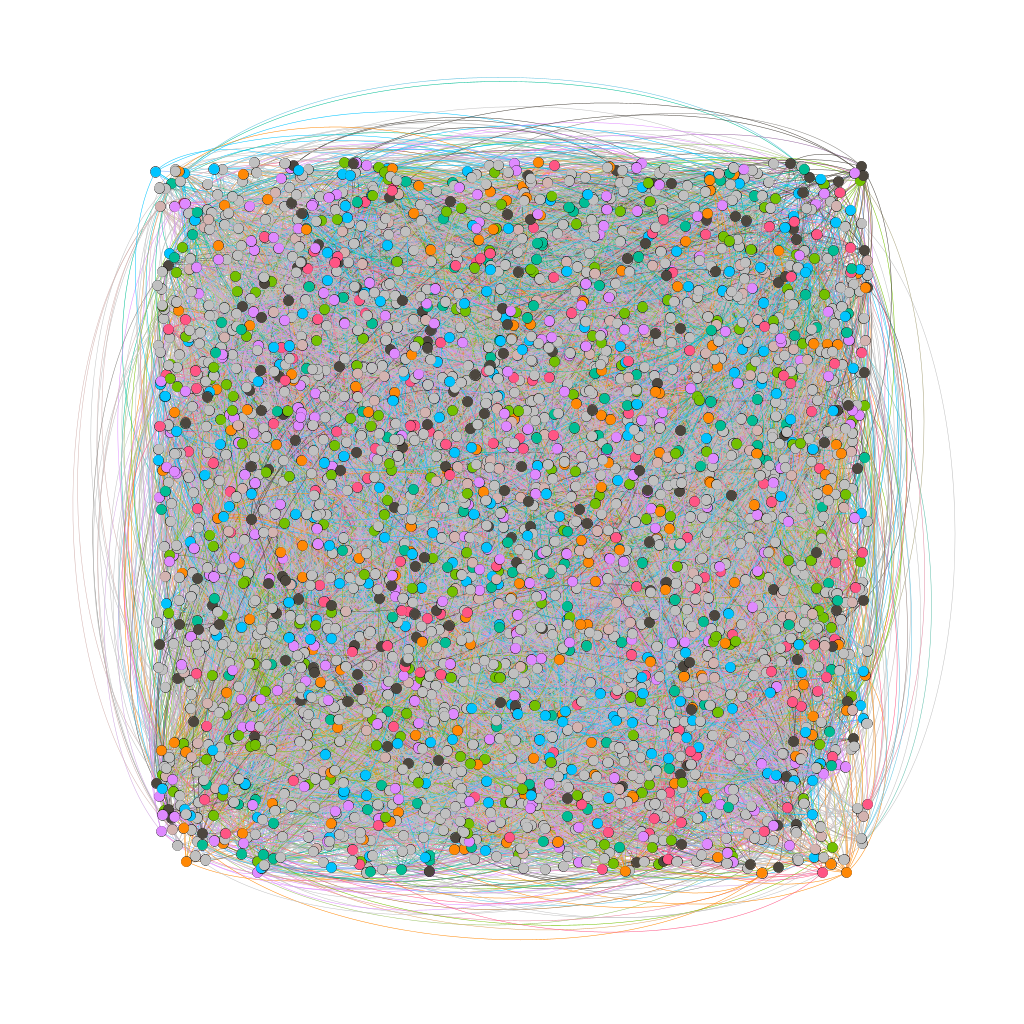

In [154]:
# Lets take a detour to Network Analytics using a WYSIWYG software called Gephi (Download here).
# We can create a directed graph from spreadsheet. We can analyse eigen vectors, degree, pagerank, and modularity.
# Modularity is....

image_folder_path = os.getcwd() + "\\img\\"
# Following is the picture of directed graph
Image(filename = image_folder_path + "overall_graph.png", width=250, height=250)

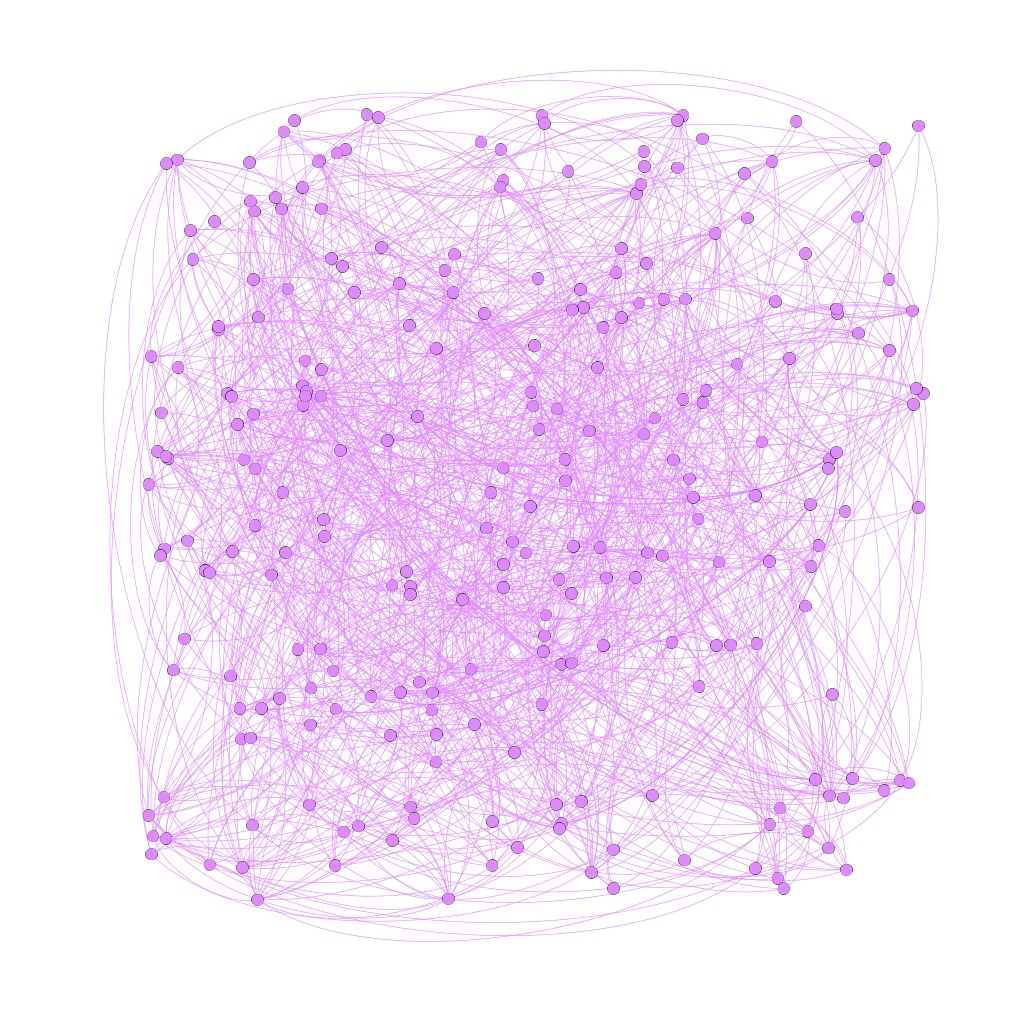

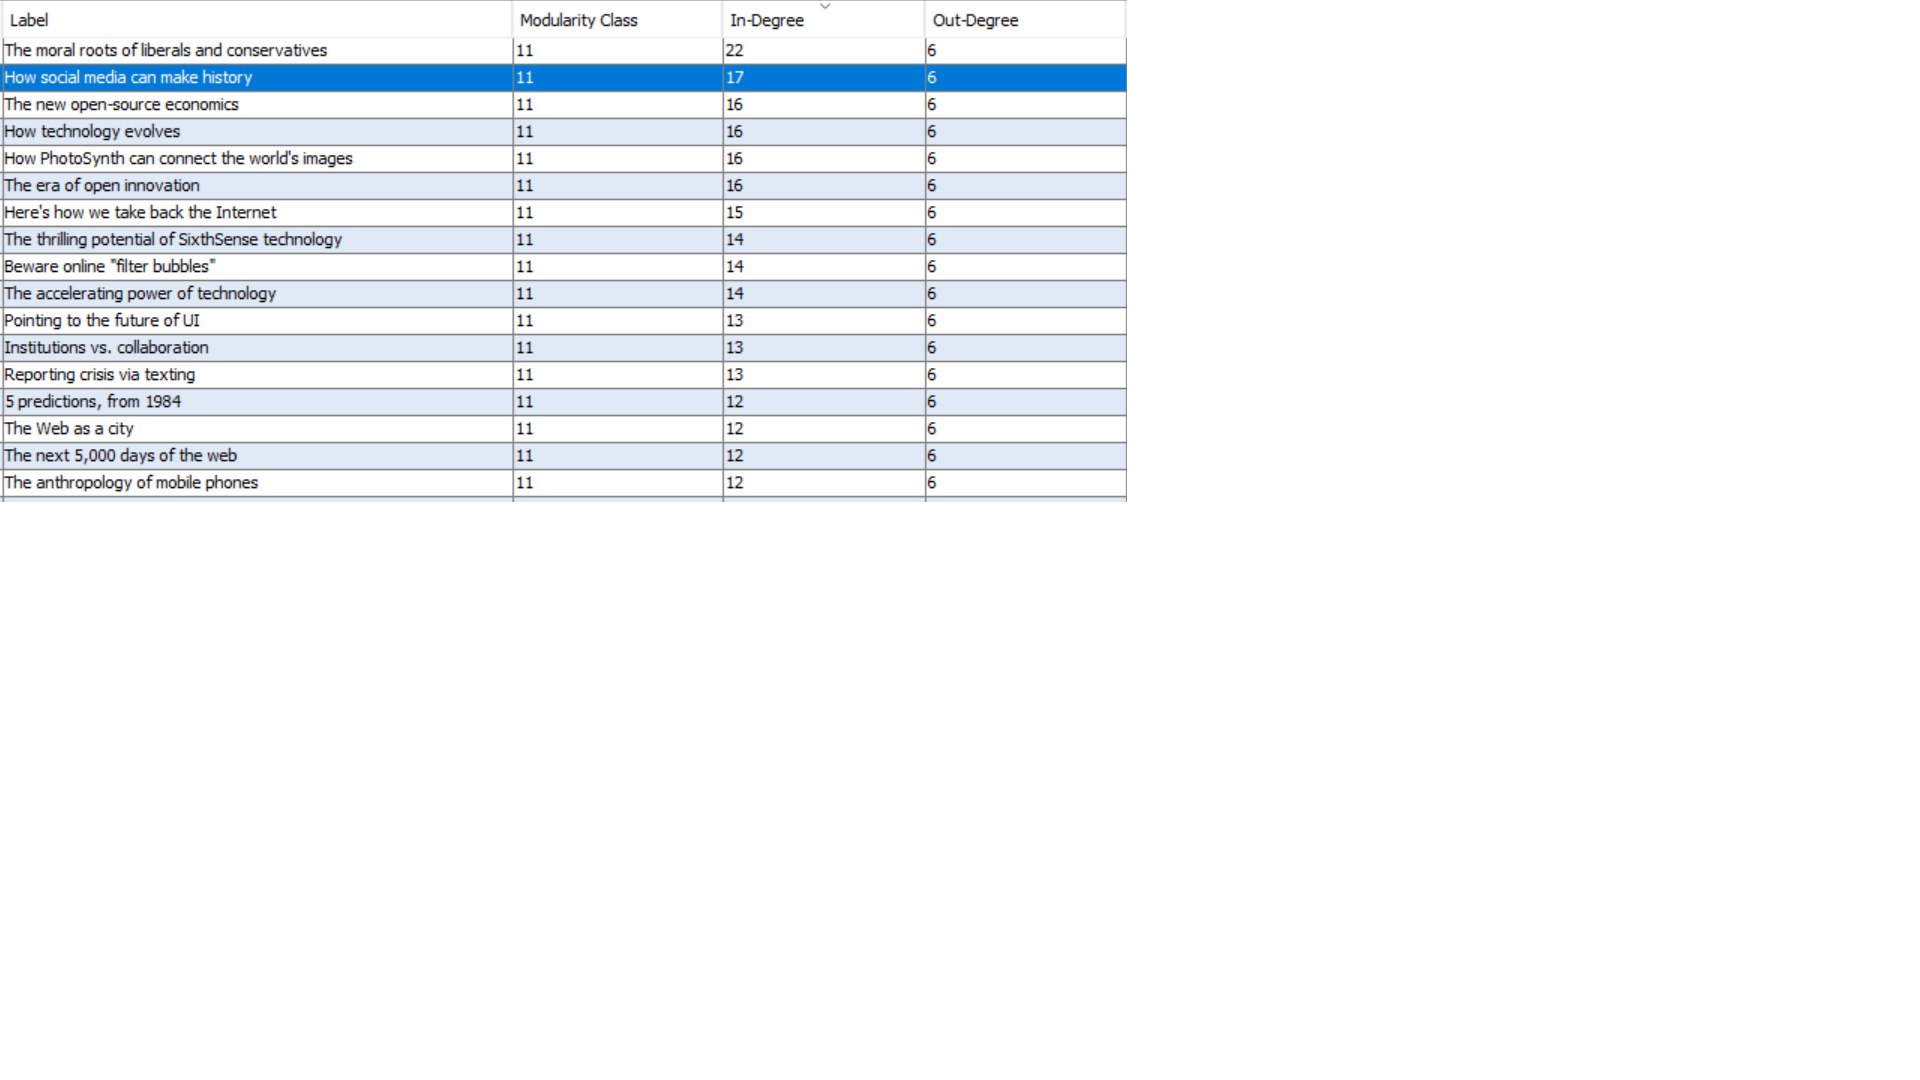

In [156]:
#Following is the picture of biggest modularity class (subgroup) and the associated data.
x = Image(filename = image_folder_path + "technology&innovation_module.png", width=250, height=250)
y = Image(filename = image_folder_path + "technology&innovation_module_data.png", width=800, height=800)
display(x,y)

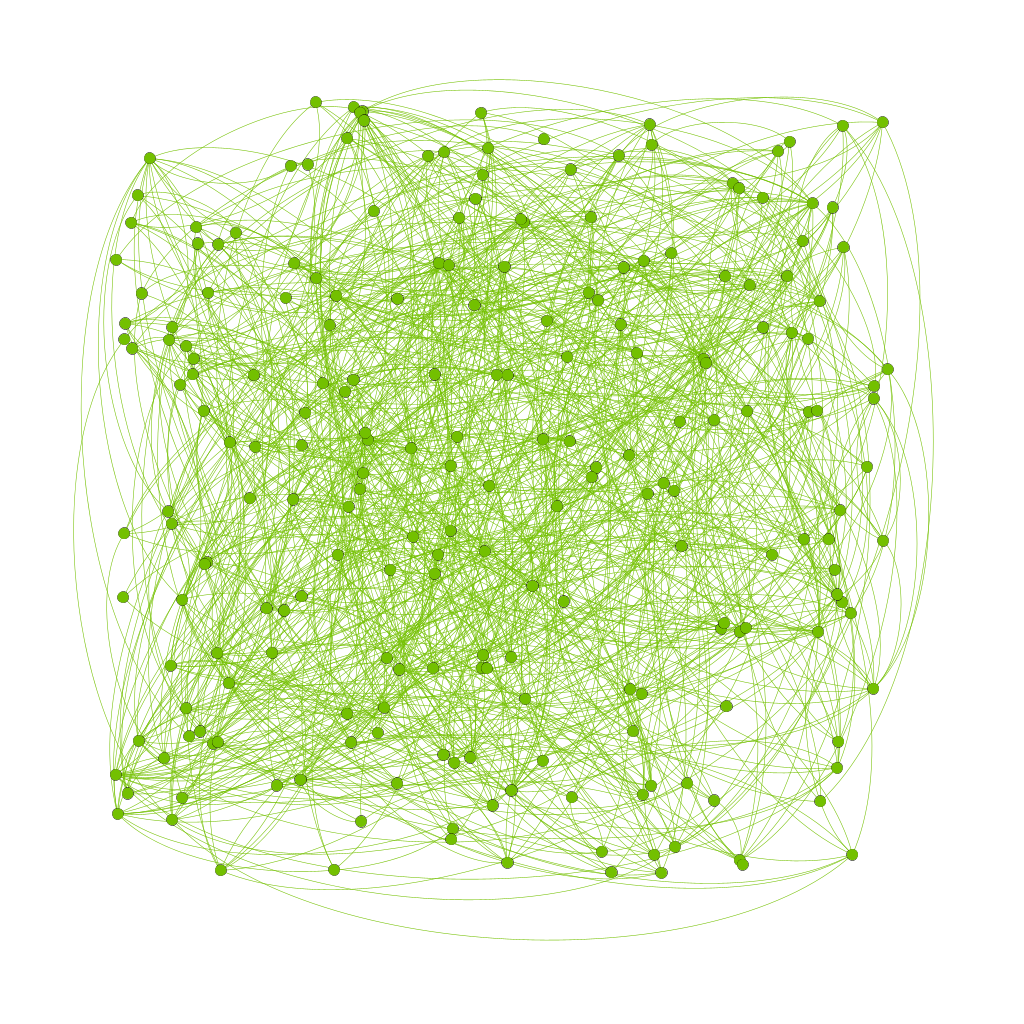

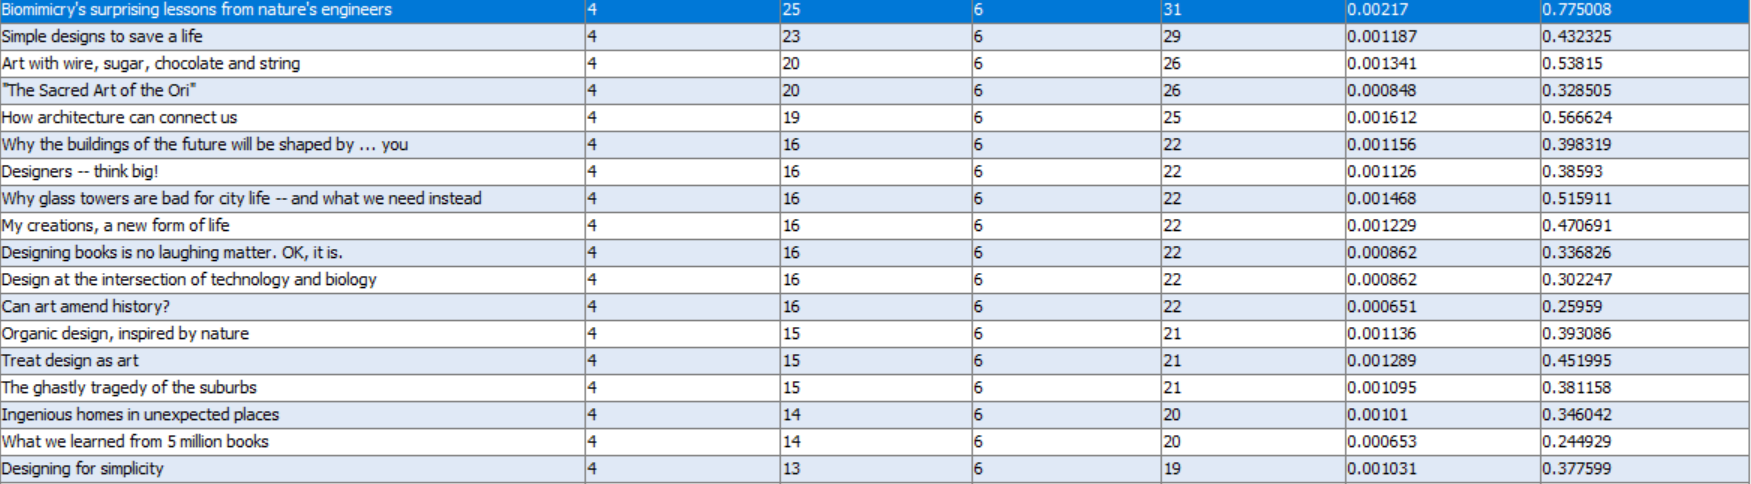

In [157]:
#Following is the picture of second biggest modularity class (subgroup) and the associated data.
x = Image(filename = image_folder_path + "art_design_arch.png", width=250, height=250)
y = Image(filename = image_folder_path + "art_design_arch_data.png", width=800, height=800)
display(x,y)

In [178]:
# We have transcript of all the talks. Hence we can create a TFIDF keywords 
# We can create a TFIDF matrix of transript terms for all talks. We will use TFIDF vectorizer of SKLearn.
tfidf_vector = TfidfVectorizer(stop_words='english')
tfidf_values = tfidf_vector.fit_transform(final_ted_df['transcript'])
tfidf_matrix = tfidf_values.toarray()
print(tfidf_matrix.shape)
#it has fonud 58795 features (columns) for 2467 ted videos (rows)

# show some 50 features out of identified 58795 features.
print(tfidf_vector.get_feature_names()[5000:5050])
# If you scroll down it has lot of features (terms) identified from transcript. 
# As we see that some of the numbers have been identified as features which could be avoided by preprocessing data.
# It will be done in the next version.

(2467, 58489)
['baldness', 'baldwin', 'baldy', 'bale', 'baleen', 'baleful', 'balenciaga', 'balers', 'bales', 'balfour', 'bali', 'balikpapan', 'balinese', 'balk', 'balkan', 'balkans', 'balked', 'balkh', 'balkhi', 'ball', 'ballads', 'ballah', 'ballard', 'ballast', 'ballasted', 'ballbot', 'ballbots', 'balled', 'ballerina', 'ballet', 'balletic', 'ballets', 'ballgame', 'ballistic', 'ballistically', 'ballistics', 'ballmer', 'balloon', 'ballooning', 'balloonist', 'balloons', 'ballot', 'ballots', 'ballpark', 'ballplayer', 'ballpoint', 'ballroom', 'ballrooms', 'balls', 'ballsy']


In [163]:
#Now that we are done with eigen vectors and TFIDF. 
# For search query entered we need to create matching scores word in search query for all TED videos and sum them.
# Since we intend to show top 5 searches, we will show the top 5 TED videos based on matching scores.

#search_query = "schools"
#search_query = "technology and robots"
search_query = "inspiration and courage"

In [164]:
# Matching score for all the TED videos.
# Get search tokens in the search query
search_tokens = search_query.split(" ")

# Find the index of all search tokens in feature names obtained from TFIDF vectorizer.
feature_names = tfidf_vector.get_feature_names()
token_indexes = list()
for token in search_tokens:
    if token in feature_names:
        index = feature_names.index(token)
        token_indexes.append(index)
if len(token_indexes) == 0:
    # No search term found in the feature names. Return no results.
    print("No results")
else:
    print(token_indexes)
    matching_scores = np.zeros(2467)
    for index in token_indexes:
        matching_scores = np.add(matching_scores, tfidf_matrix[:,index])

print(matching_scores)
print(matching_scores.shape)

[26788, 12444]
[0.         0.         0.         ... 0.01912304 0.         0.        ]
(2467,)


In [168]:
# Create a dataframe with title,url,matching_scores,eigen vector values
search_dataframe = final_ted_df[['title','url', 'eigenvector_value']]
search_dataframe = search_dataframe.assign(matching_scores=matching_scores)
search_dataframe['total_score'] = 0.5 * search_dataframe['matching_scores'] + 0.5 * search_dataframe['eigenvector_value']
search_dataframe.sort_values(['total_score'], ascending=[False], inplace = True)
# Show the top 5 search results
print(search_dataframe.head(5)[['title','url']])

                                              title  \
2426                          Courage is contagious   
1681  I'm not your inspiration, thank you very much   
2239          It's time for women to run for office   
2196       A new way to heal hearts without surgery   
800                      The power of vulnerability   

                                                                                         url  
2426             https://www.ted.com/talks/damon_davis_what_i_saw_at_the_ferguson_protests\n  
1681   https://www.ted.com/talks/stella_young_i_m_not_your_inspiration_thank_you_very_much\n  
2239     https://www.ted.com/talks/halla_tomasdottir_it_s_time_for_women_to_run_for_office\n  
2196  https://www.ted.com/talks/franz_freudenthal_a_new_way_to_heal_hearts_without_surgery\n  
800                                 https://www.ted.com/talks/brene_brown_on_vulnerability\n  
